 <!-- SVM, Small VGG Network, ArcFace, FCapNetwork -->

In [1]:
import os
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


image_size = (224, 224, 3)
dataset_path = "data"

print('Our dataset = ')
print(os.listdir(dataset_path))

Our dataset = 
['Grupo_0', 'Grupo_1', '.DS_Store', 'Grupo_4', 'Grupo_3', 'Grupo_2', 'Grupo_5']


Step 1: Loading DataSet, LG Folder - 29 Subjects, with one corrupt sample

In [2]:
def load_images_from_folder(folder_path, max_depth=5):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    for root, dirs, files in os.walk(folder_path):
        current_depth = root[len(folder_path):].count(os.sep)

        if ('IriTech' in root) or ('Iritech' in root) or ('iriTech' in root) or ('iritech' in root):
            continue

        if current_depth <= max_depth:
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    img_path = os.path.join(root, file)
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            # Resize image to 224x224x3 for ResNet50
                            img = cv2.resize(img, (224, 224))
                            images.append(img)
                            # Binary label, '0' means Fit for Duty, others alcoholic
                            labels.append(file[6] != '0')
                            names.append(file)
                    except:
                        corruptedFiles.append(img_path)
        else:
            del dirs[:]

    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")
    return np.array(images), np.array(labels), np.array(names)

images, labels, names = load_images_from_folder(dataset_path)
print(f"Read {len(images)} images from the data folder with shape {images.shape}")


Following 0 files are corrupt or encountered error: 
 []
Read 2820 images from the data folder with shape (2820, 224, 224, 3)


Randome index: 593


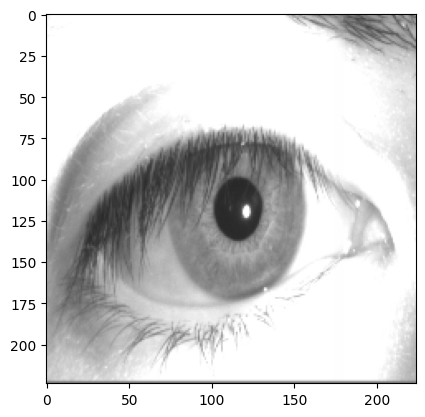

In [3]:
ri = random.randint(0, len(images) - 1)
print("Randome index: " + str(ri))
plt.imshow(images[ri])

Step 2: Split images and labels into 80-20 random train test split and train cnn

In [4]:
# Split the dataset into 70% train and 30% test
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Normalize the image data
images_train = images_train / 255.0
images_test = images_test / 255.0


labels_train_cnn = to_categorical(labels_train, num_classes=2)
labels_test_cnn = to_categorical(labels_test, num_classes=2)

In [5]:
weights_path = "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = ResNet50(weights=weights_path, include_top=False, input_shape=image_size)

base_model.trainable = False

cnn_model = Sequential([
    base_model,  
    Flatten(),  
    Dense(128, activation='relu'),
    Dropout(0.5),  
    Dense(2, activation='softmax')  
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
print(f"Train images count: {len(images_train)}")
print(f"Image Shape {images_train[0].shape}")
print(f"Test images count: {len(images_test)}")

Train images count: 1974
Image Shape (224, 224, 3)
Test images count: 846


In [7]:
#Augmentations
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [8]:
cnn_model.fit(
    images_train,
    labels_train_cnn,
    epochs=10,
    validation_data=(images_test, labels_test_cnn)
)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.6944 - loss: 3.0098 - val_accuracy: 0.8050 - val_loss: 0.5050
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 59s 965ms/step - accuracy: 0.7862 - loss: 0.5808 - val_accuracy: 0.8050 - val_loss: 0.5472
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 59s 949ms/step - accuracy: 0.7915 - loss: 0.5866 - val_accuracy: 0.8050 - val_loss: 0.5139
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 58s 942ms/step - accuracy: 0.7989 - loss: 0.5596 - val_accuracy: 0.8050 - val_loss: 0.5492
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 59s 952ms/step - accuracy: 0.7915 - loss: 0.5619 - val_accuracy: 0.8050 - val_loss: 0.5178
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 59s 949ms/step - accuracy: 0.7984 - loss: 0.5486 - val_accuracy: 0.8050 - val_loss: 0.5332
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7892 - loss: 0.5534 - val_accuracy: 0.8050 - val_loss: 0.5090
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.7942 - loss: 0.5255 - val_accuracy: 0.8

In [9]:
#Testing model
cnn_loss, cnn_accuracy = cnn_model.evaluate(images_test, labels_test_cnn)
print(f"CNN Test Accuracy: {cnn_accuracy * 100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 630ms/step - accuracy: 0.8255 - loss: 0.4680
CNN Test Accuracy: 80.50%


In [10]:
predictions = cnn_model.predict(images_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels_test_cnn, axis=1)

report = classification_report(true_classes, predicted_classes, target_names=['Fit for Duty', 'Alcoholic'])
print(report)

accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Overall Accuracy: {accuracy * 100:.2f}%')

27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 842ms/step
              precision    recall  f1-score   support

Fit for Duty       0.00      0.00      0.00       165
   Alcoholic       0.80      1.00      0.89       681

    accuracy                           0.80       846
   macro avg       0.40      0.50      0.45       846
weighted avg       0.65      0.80      0.72       846

Overall Accuracy: 80.50%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Demonstration

In [11]:
totalTest = 0
correctTest = 0

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Text(0.5, 1.0, 'Name: E_2_1_2_L_M_N_N_1980_9_2017.bmp\n\nPrediction: Fit for duty\nActual: Alcoholic\n\nAccuracy: 0.0')

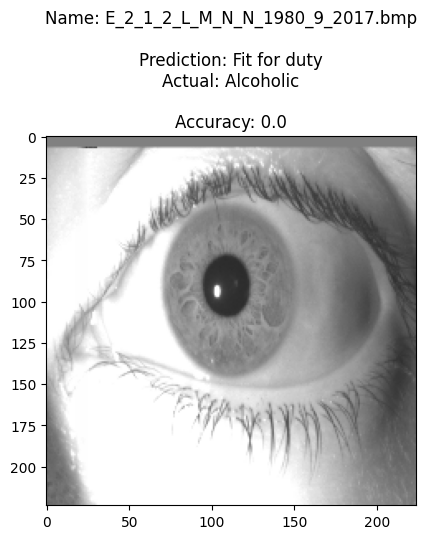

In [12]:
# testImagePath = 'images/test2.png'
# testImg = cv2.imread(testImagePath, cv2.IMREAD_GRAYSCALE)

r_in = random.randint(0, len(images) - 1)

testImg = images[r_in]
testLabel = labels[r_in]
# testImg = cv2.resize(testImg, image_size)

plt.imshow(testImg, cmap='gray')

testImg = np.expand_dims(testImg, axis=0)

print(testImg.shape)

prediction = cnn_model.predict(testImg)
prediction = np.argmax(prediction[0])

totalTest +=1
correctTest += prediction==testLabel

prediction = 'Alcoholic' if prediction else 'Fit for duty'
testLabel = 'Alcoholic' if testLabel else 'Fit for duty'
plt.title(f'Name: {names[r_in]}\n\nPrediction: {prediction}\nActual: {testLabel}\n\nAccuracy: {correctTest/totalTest}')

In [19]:
cnn_model.save("./Models/ResNet50Classification/NonAugmented.keras")